# Bayesian optimization of SVM

In [54]:
%matplotlib inline

# Load the Python scripts that contain the Bayesian optimization code
%run ./../python/gp.py
%run ./../python/plotters.py

To see how this algorithm behaves, we'll use it on a classification task. Luckily for us, scikit-learn provides helper functions like `make_classification()`, to build dummy data sets that can be used to test classifiers.

We'll optimize the penalization parameter $C$, and kernel parameter $\gamma$, of a support vector machine, with RBF kernel. The loss function we will use is the cross-validated area under the curve (AUC), based on three folds.

In [59]:
data, target = make_classification(n_samples=2500,
                                   n_features=45,
                                   n_informative=15,
                                   n_redundant=5)

def sample_loss(params):
    return cross_val_score(SVC(C=10 ** params[0], gamma=10 ** params[1], random_state=12345),
                           X=data, y=target, scoring='roc_auc', cv=3).mean()

Because this is a relatively simple problem, we can actually compute the loss surface as a function of $C$ and $\gamma$. This way, we can get an accurate estimate of where the true optimum of the loss surface is.

In [60]:
lambdas = np.linspace(1, -4, 25)
gammas = np.linspace(1, -4, 20)

# We need the cartesian combination of these two vectors
param_grid = np.array([[C, gamma] for gamma in gammas for C in lambdas])

real_loss = [sample_loss(params) for params in param_grid]

# The maximum is at:
param_grid[np.array(real_loss).argmax(), :]

array([ 0.375     , -1.89473684])

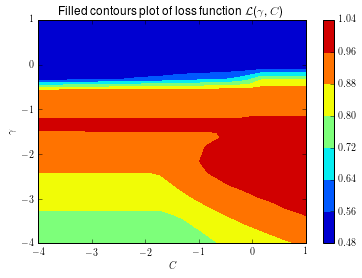

In [63]:
from matplotlib import rc
rc('text', usetex=True)

C, G = np.meshgrid(lambdas, gammas)
plt.figure()
cp = plt.contourf(C, G, np.array(real_loss).reshape(C.shape))
plt.colorbar(cp)
plt.title('Filled contours plot of loss function $\mathcal{L}$($\gamma$, $C$)')
plt.xlabel('$C$')
plt.ylabel('$\gamma')
plt.savefig('/Users/thomashuijskens/Personal/gp-optimisation/figures/real_loss_contour.png', bbox_inches='tight')
plt.show()

For the underlying GP, we'll assume a [Matern](http://scikit-learn.org/stable/modules/gaussian_process.html#matern-kernel) kernel as the covariance function. Although we skim over the selection of the kernel here, in general the behaviour of the algorithm is dependent on the choice of the kernel. Using a Matern kernel, with the default parameters, means we implicitly assume the loss $f$ is at least once differentiable. [There are a number of kernels available](http://scikit-learn.org/stable/modules/gaussian_process.html#kernels-for-gaussian-processes) in scikit-learn, and each kernel implies a different assumption on the behaviour of the loss $f$.

In [27]:
bounds = np.array([[-4, 1], [-4, 1]])

xp, yp = bayesian_optimisation(n_iters=30, 
                               sample_loss=sample_loss, 
                               bounds=bounds,
                               n_pre_samples=3,
                               random_search=100000)

/Users/thomashuijskens/anaconda3/envs/python3-stats/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 54, 'nit': 7, 'grad': array([ -2.19171827e-05]), 'warnflag': 2}
  " state: %s" % convergence_dict)
/Users/thomashuijskens/anaconda3/envs/python3-stats/lib/python3.5/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'task': b'ABNORMAL_TERMINATION_IN_LNSRCH', 'funcalls': 59, 'nit': 6, 'grad': array([ -1.67384713e-05]), 'warnflag': 2}
  " state: %s" % convergence_dict)


The animation below shows the sequence of points selected, if we run the Bayesian optimization algorithm in this setting. The star shows the value of $C$ and $\gamma$ that result in the largest value of cross-validated AUC.

/Users/thomashuijskens/anaconda3/envs/python3-stats/lib/python3.5/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


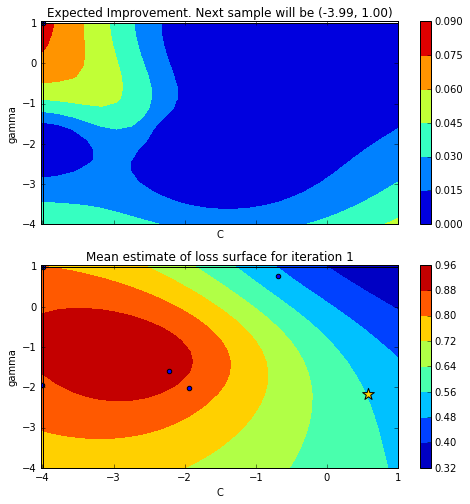

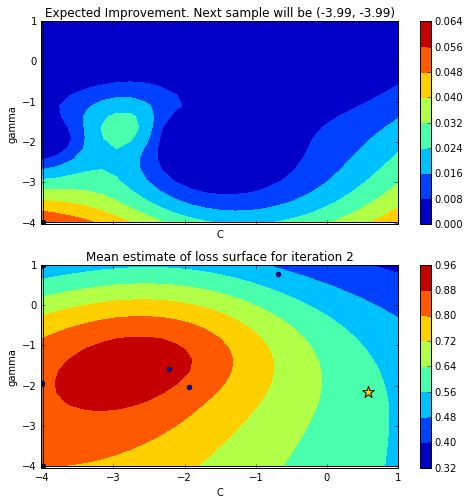

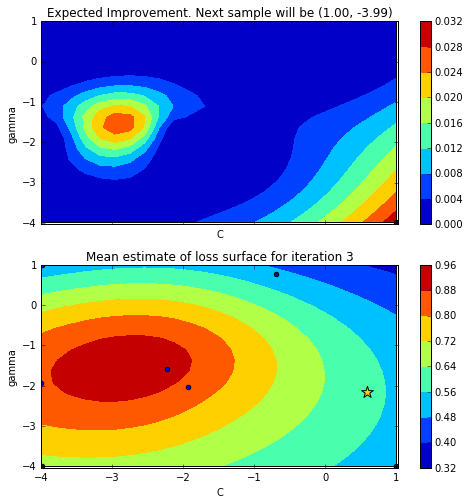

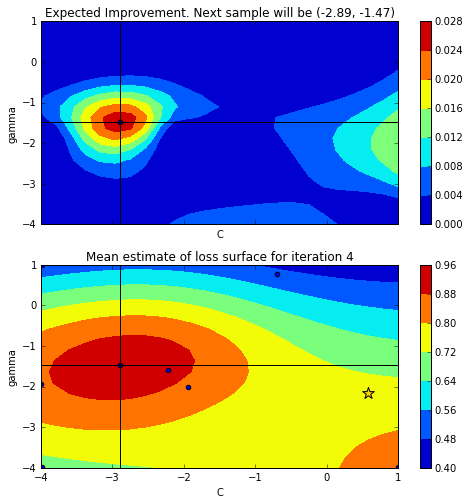

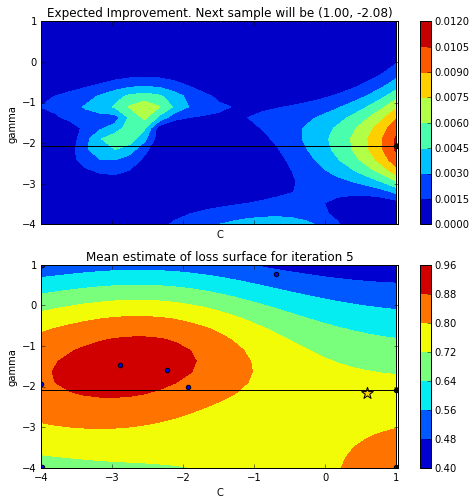

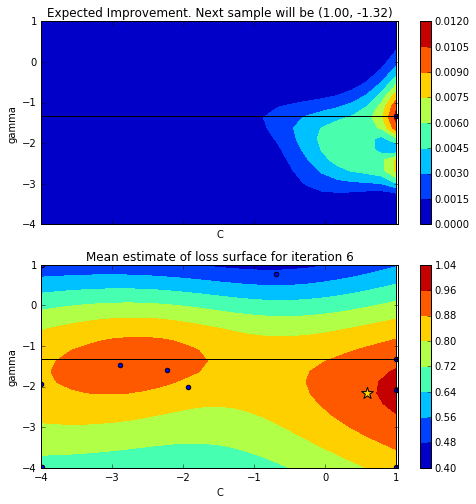

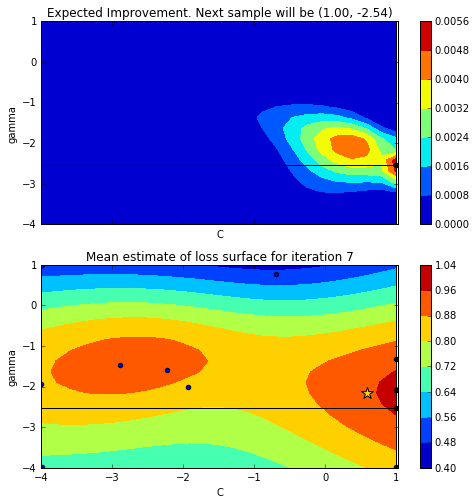

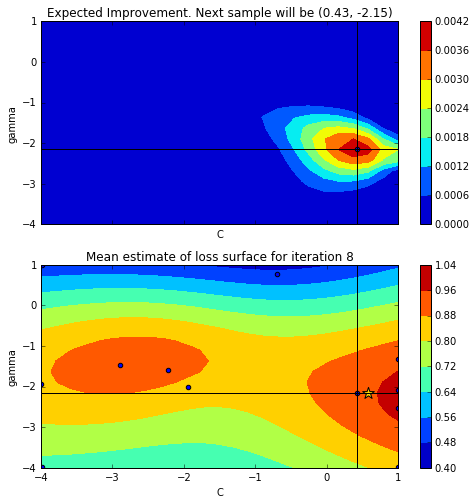

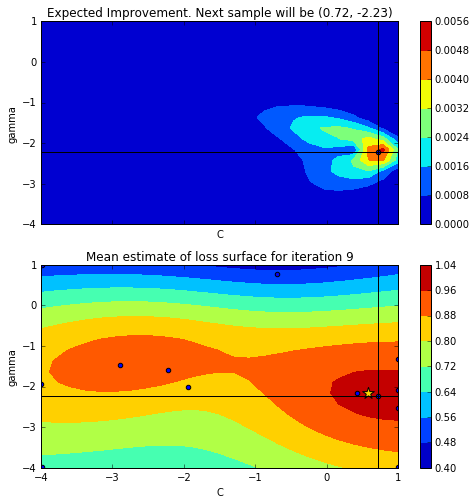

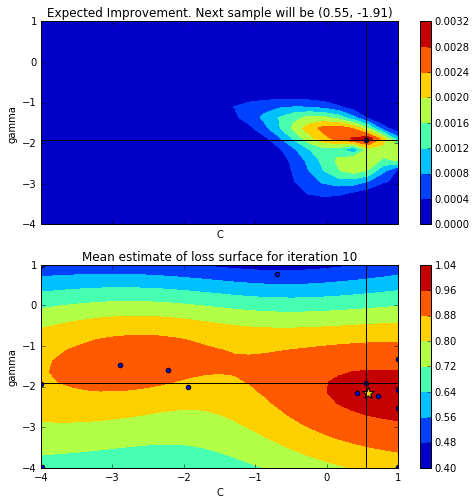

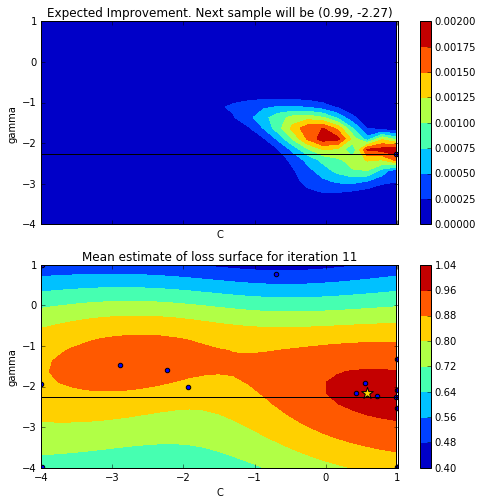

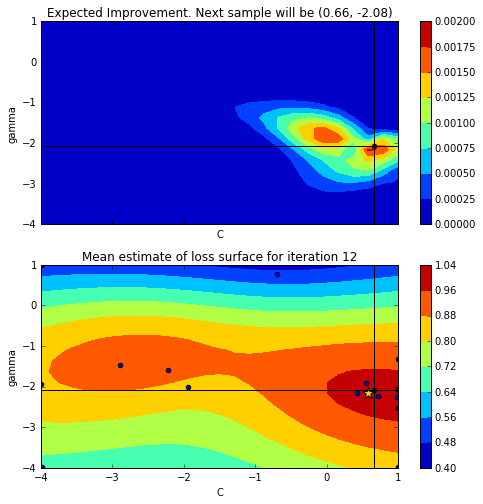

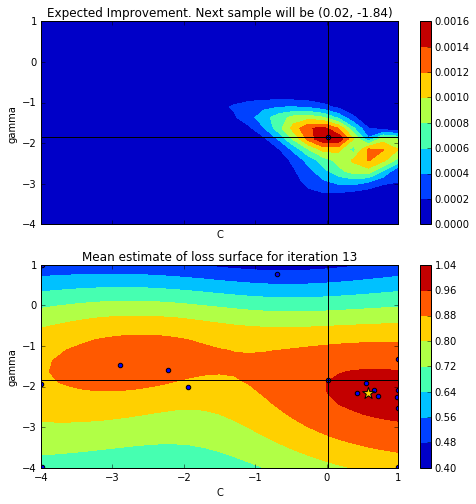

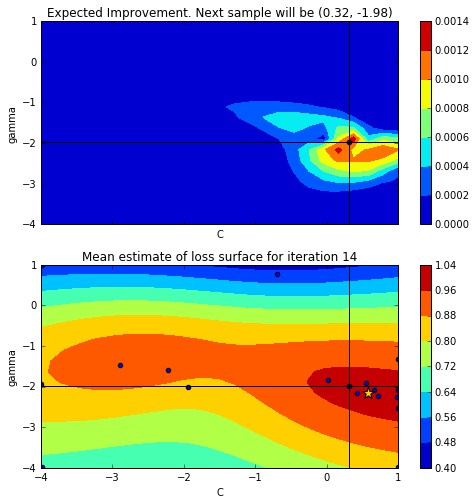

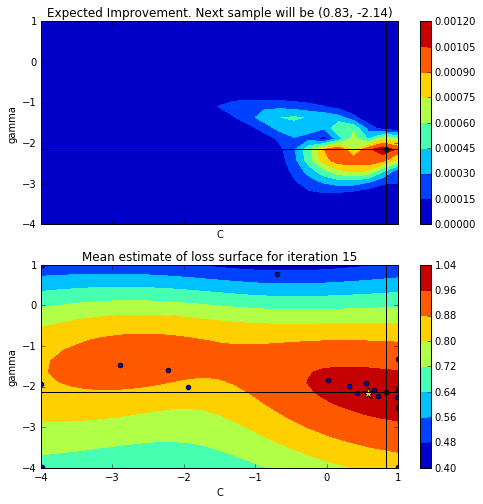

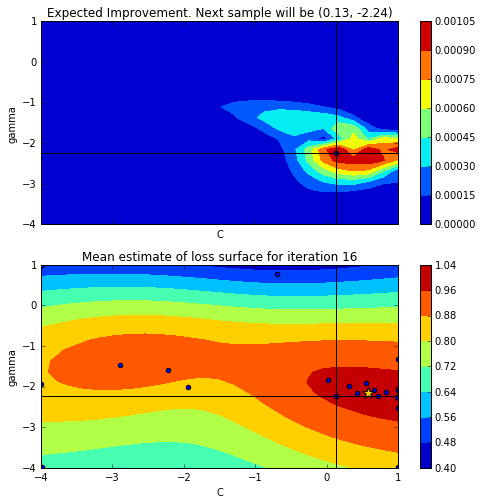

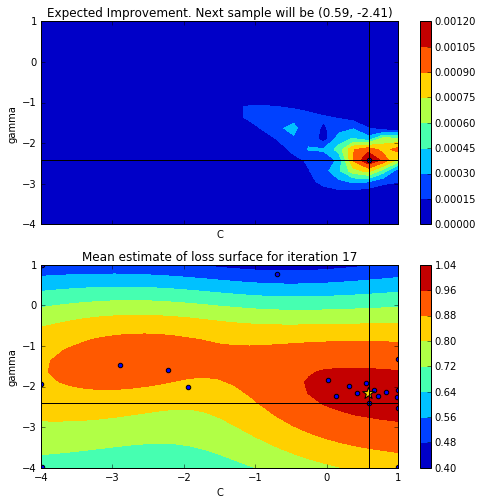

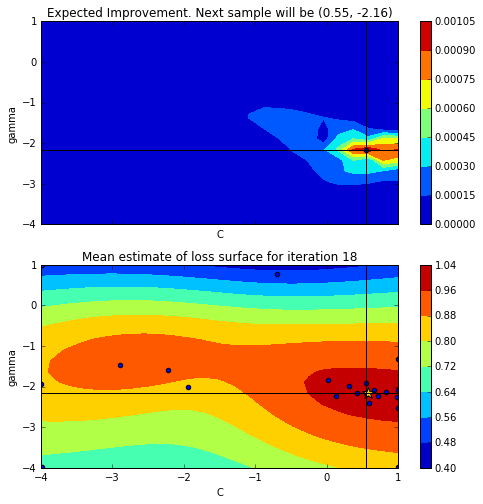

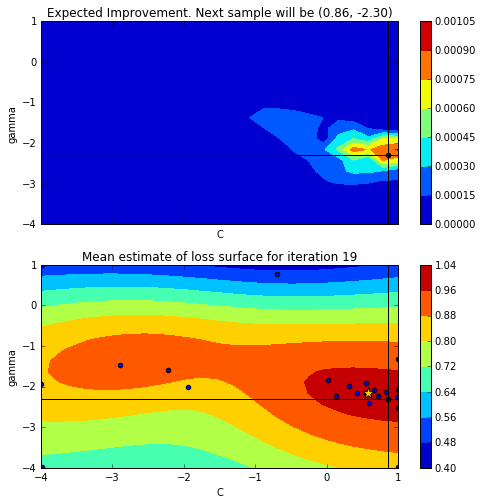

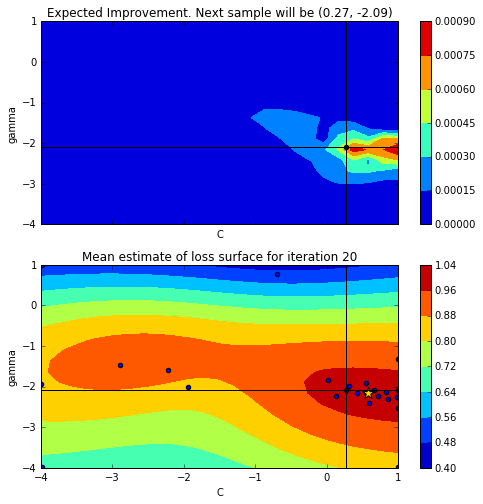

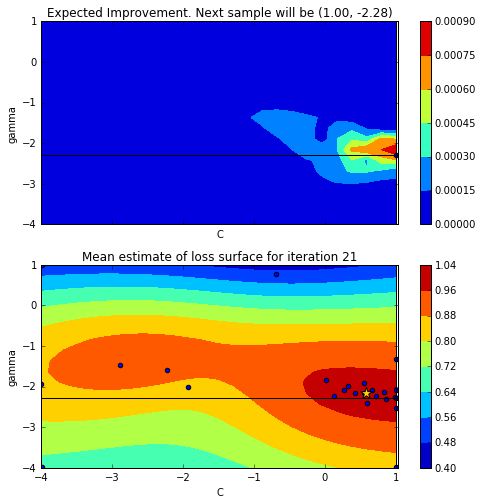

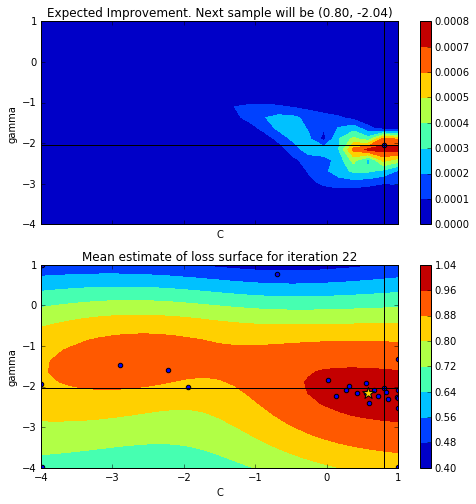

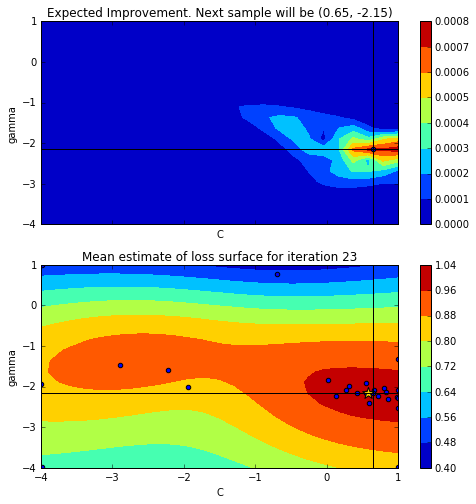

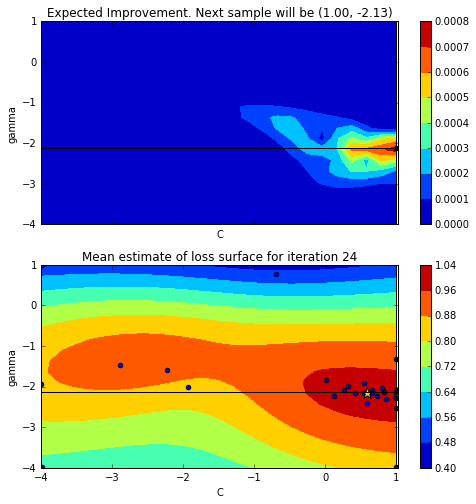

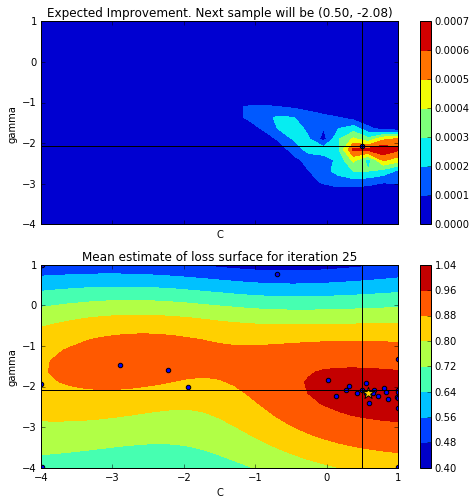

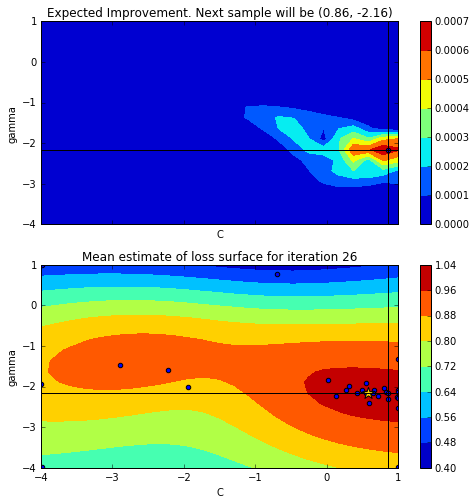

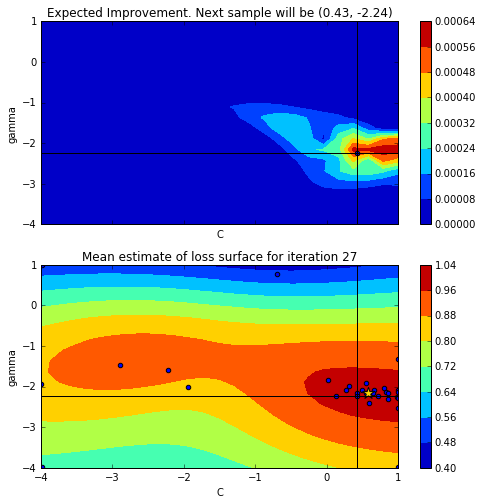

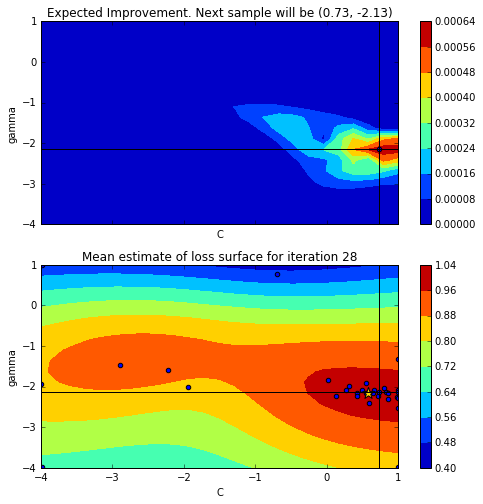

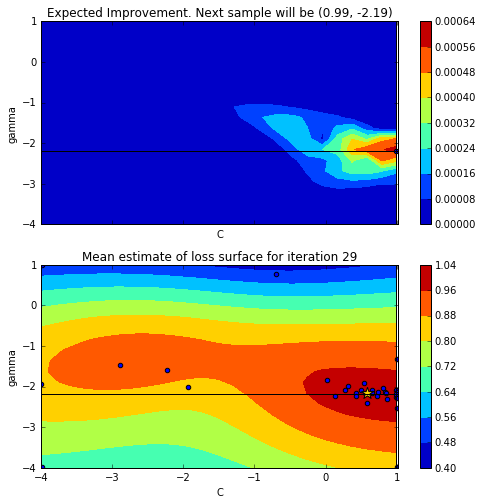

In [55]:
rc('text', usetex=False)
plot_iteration(lambdas, xp, yp, first_iter=3, second_param_grid=gammas, optimum=[0.58333333, -2.15789474])

In [65]:
# Create a gif from the images
import imageio
images = []

for i in range(3, 23):
    filename = "/Users/thomashuijskens/Personal/gp-optimisation/figures/bo_iteration_%d.png" % i 
    images.append(imageio.imread(filename))
    
imageio.mimsave('/Users/thomashuijskens/Personal/gp-optimisation/figures/bo_2d_new_data.gif', images, duration=1.0)